<a href="https://colab.research.google.com/github/mmontielpz/premier-data-scout/blob/main/data_proces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1

In [ ]:
# ==========================
# 1️⃣ Install & Import Libraries
# ==========================
!pip install soccerdata

import soccerdata as sd
import pandas as pd
import numpy as np
import re

# ==========================
# 2️⃣ Load & Clean EPL Salaries Data (Keep Separate)
# ==========================

# Load EPL Salaries dataset
epl_salaries = pd.read_csv("/content/soccer_salaries.csv")

# Standardize column names
epl_salaries.columns = epl_salaries.columns.str.strip().str.lower()

# Rename 'player name' column to 'player' for consistency
epl_salaries.rename(columns={'player name': 'player'}, inplace=True)

# Function to clean currency values
def clean_currency(value):
    if isinstance(value, str):
        return float(value.replace("£", "").replace(",", "").strip())  # Remove currency symbols & commas
    return value  # If already numeric, return as is

# Apply cleaning function to salary columns
epl_salaries["weekly wage"] = epl_salaries["weekly wage"].apply(clean_currency)
epl_salaries["yearly salary"] = epl_salaries["yearly salary"].apply(clean_currency)

print("✅ EPL Salaries Dataset Cleaned & Standardized")
print(epl_salaries.head())

# ==========================
# 3️⃣ Fetch Player Stats from FBref (Keep Separate)
# ==========================

# Initialize FBref for the English Premier League (2024 season)
fbref = sd.FBref(leagues="ENG-Premier League", seasons=2024)

# Get player stats (Stored separately, no merging)
player_creation_stats = fbref.read_player_season_stats(stat_type="goal_shot_creation")
player_def_stats = fbref.read_player_season_stats(stat_type="defense")
player_misc_stats = fbref.read_player_season_stats(stat_type="misc")  # Used for age correction

# ==========================
# 4️⃣ Fix MultiIndex Columns
# ==========================

# Function to flatten MultiIndex columns
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join(col).strip("_") if isinstance(col, tuple) else col.strip("_") for col in df.columns]
    return df

# Apply column flattening
player_creation_stats = flatten_columns(player_creation_stats)
player_def_stats = flatten_columns(player_def_stats)
player_misc_stats = flatten_columns(player_misc_stats)

# Reset index if necessary
for df in [player_creation_stats, player_def_stats, player_misc_stats]:
    df.reset_index(inplace=True)

# ==========================
# 5️⃣ Extract Correct Age from player_misc_stats (Keep Separate)
# ==========================

# Function to extract the correct age (first two digits)
def extract_age(value):
    """Extracts the first two digits from the age column as an integer."""
    if isinstance(value, str):
        match = re.search(r"\d{2}", value)  # Find the first two digits
        if match:
            return int(match.group(0))  # Convert to integer
    return None  # Return None if not found

# Apply regex extraction for correct age
player_misc_stats["age"] = player_misc_stats["age"].astype(str).apply(extract_age)
player_creation_stats["age"] = player_creation_stats["age"].astype(str).apply(extract_age)
player_def_stats["age"] = player_def_stats["age"].astype(str).apply(extract_age)

# ==========================
# 6️⃣ Fix Missing Age Values (Independently for Each Dataset)
# ==========================
for df in [player_creation_stats, player_def_stats, player_misc_stats]:
    df["age"] = pd.to_numeric(df["age"], errors="coerce").fillna(0).astype(int)
    mean_age = df["age"].replace(0, np.nan).mean()
    df["age"].replace(0, mean_age, inplace=True)  # Replace 0 ages with the average

# ==========================
# 7️⃣ On-Demand Filtering for Players
# ==========================

# Instead of merging, we filter by player names when needed

def get_player_info(player_name):
    """Retrieve salary, age, and stats for a given player name."""
    salary_info = epl_salaries[epl_salaries["player"] == player_name]
    age_info = player_misc_stats[player_misc_stats["player"] == player_name]["age"].values
    creation_stats = player_creation_stats[player_creation_stats["player"] == player_name]
    defense_stats = player_def_stats[player_def_stats["player"] == player_name]

    return {
        "salary": salary_info,
        "age": age_info[0] if len(age_info) > 0 else None,
        "creation_stats": creation_stats,
        "defense_stats": defense_stats
    }


✅ EPL Salaries Dataset Cleaned & Standardized
   unnamed: 0           player  weekly wage  yearly salary  age   position  \
0           0             Neto     100000.0      5200000.0   33         GK   
1           1  Dominic Solanke      72000.0      3744000.0   25         ST   
2           2  Justin Kluivert      70000.0      3640000.0   24      AM RL   
3           3   Philip Billing      54000.0      2808000.0   27   DM, AM C   
4           4       Alex Scott      53000.0      2756000.0   19  DM, AM RC   

   nationality             team  
0       Brazil  afc-bournemouth  
1      England  afc-bournemouth  
2  Netherlands  afc-bournemouth  
3      Denmark  afc-bournemouth  
4      England  afc-bournemouth  


[03/15/25 17:29:26] INFO     Saving cached data to /root/soccerdata/data/FBref                       ]8;id=365176;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=591574;file:///usr/local/lib/python3.11/dist-packages/soccerdata/_common.py#263\263]8;;\

                    WARNING  /usr/local/lib/python3.11/dist-packages/soccerdata/fbref.py:165:       ]8;id=35937;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=776453;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             FutureWarning: The behavior of DataFrame concatenation with empty or                  
                             all-NA entries is deprecated. In a future version, this will no longer                
                             exclude empty or all-NA columns when determining the result dtypes. To                
                             retain the old behavior, exclude the relevant entries before the                      
                             concat operation.                                                                     
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  /usr/local/lib/python3.11/dist-packages/soccerdata/fbref.py:165:       ]8;id=790476;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=850308;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             FutureWarning: The behavior of DataFrame concatenation with empty or                  
                             all-NA entries is deprecated. In a future version, this will no longer                
                             exclude empty or all-NA columns when determining the result dtypes. To                
                             retain the old behavior, exclude the relevant entries before the                      
                             concat operation.                                                                     
                               pd.concat(dfs)                                                                      
                                                                                                                   

[03/15/25 17:29:27] WARNING  /usr/local/lib/python3.11/dist-packages/soccerdata/fbref.py:165:       ]8;id=553539;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=813820;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             FutureWarning: The behavior of DataFrame concatenation with empty or                  
                             all-NA entries is deprecated. In a future version, this will no longer                
                             exclude empty or all-NA columns when determining the result dtypes. To                
                             retain the old behavior, exclude the relevant entries before the                      
                             concat operation.                                                                     
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  <ipython-input-21-036eac75d0c0>:92: FutureWarning: A value is trying   ]8;id=413038;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=275872;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             to be set on a copy of a DataFrame or Series through chained                          
                             assignment using an inplace method.                                                   
                             The behavior will change in pandas 3.0. This inplace method will never                
                             work because the intermediate object on which we are setting values                   
                             always behaves as a copy.                                                             
                                                                                                                   
                             For example, when doing 'df.method(value, inplace=True)', try using                   
                             'df.method({col: value}, inplace=True)' or df = df.method(value)                      
                             instead, to perform the operation inplace on the original object.                     
                                                                                                                   
                                                                                                                   
                               df["age"].replace(0, mean_age, inplace=True)  # Replace 0 ages with                 
                             the average                                                                           
                                                                                                                   

                    WARNING  <ipython-input-21-036eac75d0c0>:92: FutureWarning: A value is trying   ]8;id=653368;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=743478;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             to be set on a copy of a DataFrame or Series through chained                          
                             assignment using an inplace method.                                                   
                             The behavior will change in pandas 3.0. This inplace method will never                
                             work because the intermediate object on which we are setting values                   
                             always behaves as a copy.                                                             
                                                                                                                   
                             For example, when doing 'df.method(value, inplace=True)', try using                   
                             'df.method({col: value}, inplace=True)' or df = df.method(value)                      
                             instead, to perform the operation inplace on the original object.                     
                                                                                                                   
                                                                                                                   
                               df["age"].replace(0, mean_age, inplace=True)  # Replace 0 ages with                 
                             the average                                                                           
                                                                                                                   

                    WARNING  <ipython-input-21-036eac75d0c0>:92: FutureWarning: A value is trying   ]8;id=523744;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=245302;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             to be set on a copy of a DataFrame or Series through chained                          
                             assignment using an inplace method.                                                   
                             The behavior will change in pandas 3.0. This inplace method will never                
                             work because the intermediate object on which we are setting values                   
                             always behaves as a copy.                                                             
                                                                                                                   
                             For example, when doing 'df.method(value, inplace=True)', try using                   
                             'df.method({col: value}, inplace=True)' or df = df.method(value)                      
                             instead, to perform the operation inplace on the original object.                     
                                                                                                                   
                                                                                                                   
                               df["age"].replace(0, mean_age, inplace=True)  # Replace 0 ages with                 
                             the average                                                                           
                                                                                                                   

In [ ]:
player_creation_stats.head()

,league,season,team,player,nation,pos,age,born,90s,SCA_SCA,...,SCA Types_Fld,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def
0,ENG-Premier League,2425,Arsenal,Ben White,ENG,DF,27,1997,7.8,9,...,0,0,1,0.13,1,0,0,0,0,0
1,ENG-Premier League,2425,Arsenal,Bukayo Saka,ENG,"FW,MF",23,2001,14.1,89,...,3,0,21,1.49,12,5,2,1,1,0
2,ENG-Premier League,2425,Arsenal,David Raya,ESP,GK,29,1995,28.0,3,...,0,0,0,0.0,0,0,0,0,0,0
3,ENG-Premier League,2425,Arsenal,Declan Rice,ENG,MF,26,1999,23.0,84,...,5,2,7,0.3,4,2,0,1,0,0
4,ENG-Premier League,2425,Arsenal,Ethan Nwaneri,ENG,"FW,MF",17,2007,6.6,16,...,1,0,2,0.3,2,0,0,0,0,0


In [ ]:
# Define a function to calculate cost-effectiveness
def calculate_cost_effectiveness(df, salary_df, stat_column):
    df = df[df["age"] <= 25]  # Filter young players
    df = df[df[stat_column].notna()]  # Remove players without stats

    # Get salary per player
    salary_map = salary_df.drop_duplicates(subset=["player"]).set_index("player")["yearly salary"]
    df["salary"] = df["player"].map(salary_map)
    df.dropna(subset=["salary"], inplace=True)  # Remove players without salary data

    # Compute cost-effectiveness metric
    df["cost_effectiveness"] = df[stat_column] / (df["salary"] / 1000000)  # Normalize
    return df.sort_values(by="cost_effectiveness", ascending=False)

# Compute cost-effectiveness for attackers and defenders
young_attackers = calculate_cost_effectiveness(player_creation_stats, epl_salaries, "GCA_GCA")
young_defenders = calculate_cost_effectiveness(player_def_stats, epl_salaries, "Tackles_Tkl")

In [ ]:
player_creation_stats.head()

,league,season,team,player,nation,pos,age,born,90s,SCA_SCA,...,SCA Types_Fld,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def
0,ENG-Premier League,2425,Arsenal,Ben White,ENG,DF,27,1997,7.8,9,...,0,0,1,0.13,1,0,0,0,0,0
1,ENG-Premier League,2425,Arsenal,Bukayo Saka,ENG,"FW,MF",23,2001,14.1,89,...,3,0,21,1.49,12,5,2,1,1,0
2,ENG-Premier League,2425,Arsenal,David Raya,ESP,GK,29,1995,28.0,3,...,0,0,0,0.0,0,0,0,0,0,0
3,ENG-Premier League,2425,Arsenal,Declan Rice,ENG,MF,26,1999,23.0,84,...,5,2,7,0.3,4,2,0,1,0,0
4,ENG-Premier League,2425,Arsenal,Ethan Nwaneri,ENG,"FW,MF",17,2007,6.6,16,...,1,0,2,0.3,2,0,0,0,0,0


In [ ]:
young_defenders.head()

,league,season,team,player,nation,pos,age,born,90s,Tackles_Tkl,...,Challenges_Lost,Blocks_Blocks,Blocks_Sh,Blocks_Pass,Int,Tkl+Int,Clr,Err,salary,cost_effectiveness
104,ENG-Premier League,2425,Brentford,Yehor Yarmoliuk,UKR,MF,21,2004,8.6,26,...,18,22,6,16,8,34,23,0,223600.0,116.27907
411,ENG-Premier League,2425,Nott'ham Forest,Elliot Anderson,ENG,MF,22,2002,21.0,66,...,39,38,8,30,21,87,49,2,728000.0,90.659341
368,ENG-Premier League,2425,Manchester Utd,Kobbie Mainoo,ENG,MF,19,2005,14.3,37,...,13,15,2,13,17,54,6,1,520000.0,71.153846
317,ENG-Premier League,2425,Liverpool,Jarell Quansah,ENG,DF,22,2003,3.2,9,...,1,4,4,0,5,14,13,0,161200.0,55.831266
111,ENG-Premier League,2425,Brighton,Carlos Baleba,CMR,MF,21,2004,20.7,57,...,20,32,5,27,37,94,24,1,1040000.0,54.807692


                    WARNING  <ipython-input-26-d8d189bf10d2>:15: FutureWarning:                     ]8;id=656294;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=156053;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="cost_effectiveness", y="player",                                     
                             data=young_attackers.head(10), ax=axes[0], palette="Blues_r")                         
                                                                                                                   

[03/15/25 17:29:28] WARNING  <ipython-input-26-d8d189bf10d2>:21: FutureWarning:                     ]8;id=920516;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=63765;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="cost_effectiveness", y="player",                                     
                             data=young_defenders.head(10), ax=axes[1], palette="Greens_r")                        
                                                                                                                   

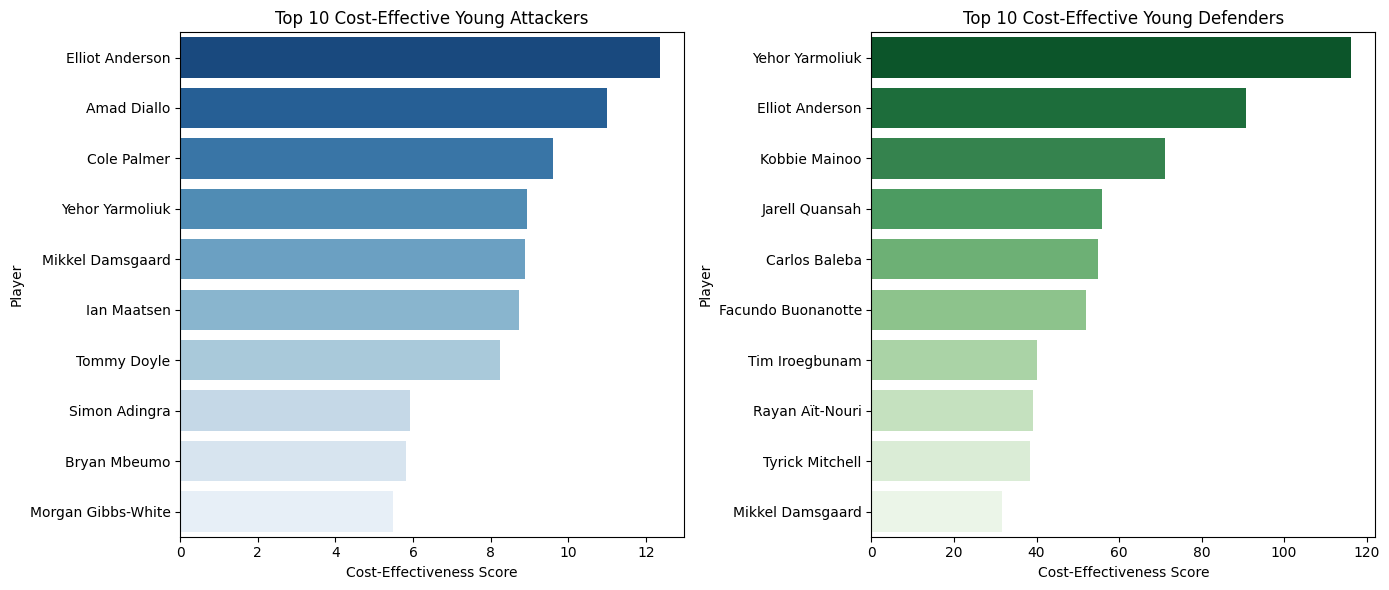

✅ Analysis completed: Top young cost-effective players identified!


In [ ]:
# ==========================
# 8️⃣ Data Visualization
# ==========================

import soccerdata as sd
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Attackers
sns.barplot(x="cost_effectiveness", y="player", data=young_attackers.head(10), ax=axes[0], palette="Blues_r")
axes[0].set_title("Top 10 Cost-Effective Young Attackers")
axes[0].set_xlabel("Cost-Effectiveness Score")
axes[0].set_ylabel("Player")

# Defenders
sns.barplot(x="cost_effectiveness", y="player", data=young_defenders.head(10), ax=axes[1], palette="Greens_r")
axes[1].set_title("Top 10 Cost-Effective Young Defenders")
axes[1].set_xlabel("Cost-Effectiveness Score")
axes[1].set_ylabel("Player")

plt.tight_layout()
plt.show()

print("✅ Analysis completed: Top young cost-effective players identified!")

                    WARNING  <ipython-input-27-2c1bce23f10b>:7: FutureWarning:                      ]8;id=792018;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=831795;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="cost_effectiveness", y="player",                                     
                             data=young_attackers.head(10), palette="Blues_r")                                     
                                                                                                                   

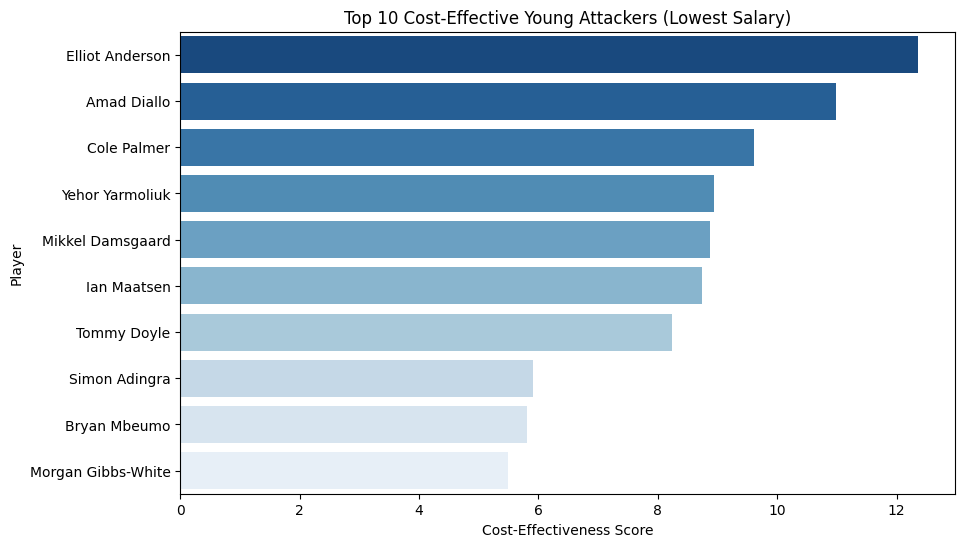

[03/15/25 17:29:29] WARNING  <ipython-input-27-2c1bce23f10b>:15: FutureWarning:                     ]8;id=673795;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=512838;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="cost_effectiveness", y="player",                                     
                             data=young_attackers.tail(10), palette="Blues_r")                                     
                                                                                                                   

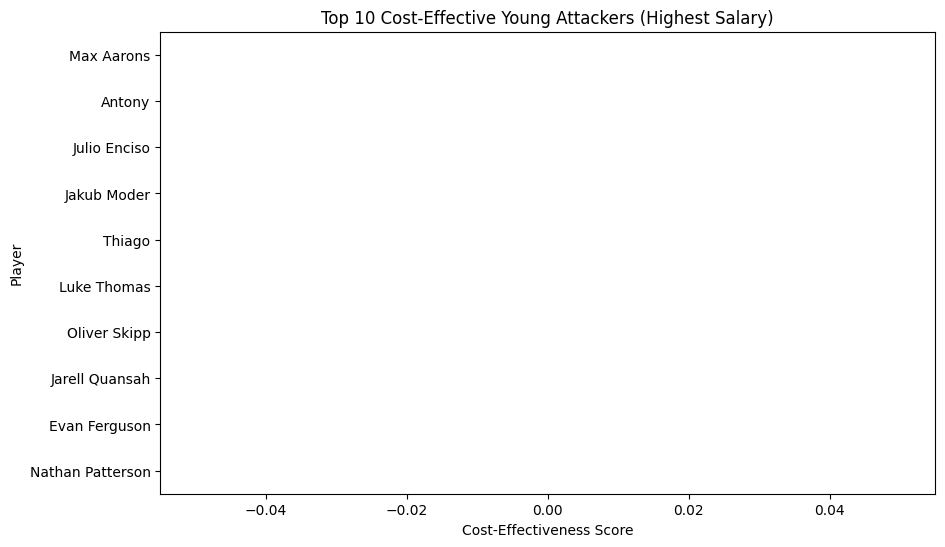

                    WARNING  <ipython-input-27-2c1bce23f10b>:23: FutureWarning:                     ]8;id=994635;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=74388;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="cost_effectiveness", y="player",                                     
                             data=young_defenders.head(10), palette="Greens_r")                                    
                                                                                                                   

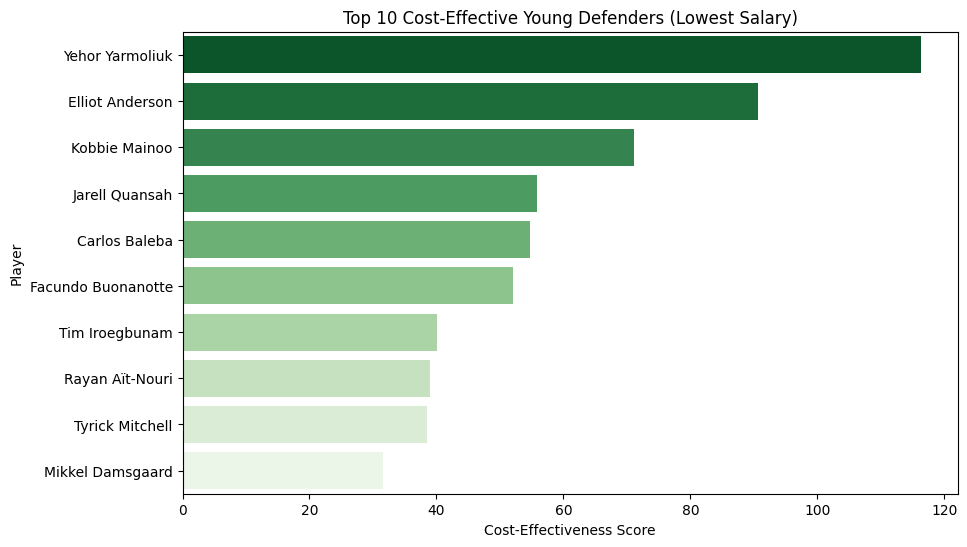

[03/15/25 17:29:30] WARNING  <ipython-input-27-2c1bce23f10b>:31: FutureWarning:                     ]8;id=825170;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=439254;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="cost_effectiveness", y="player",                                     
                             data=young_defenders.tail(10), palette="Greens_r")                                    
                                                                                                                   

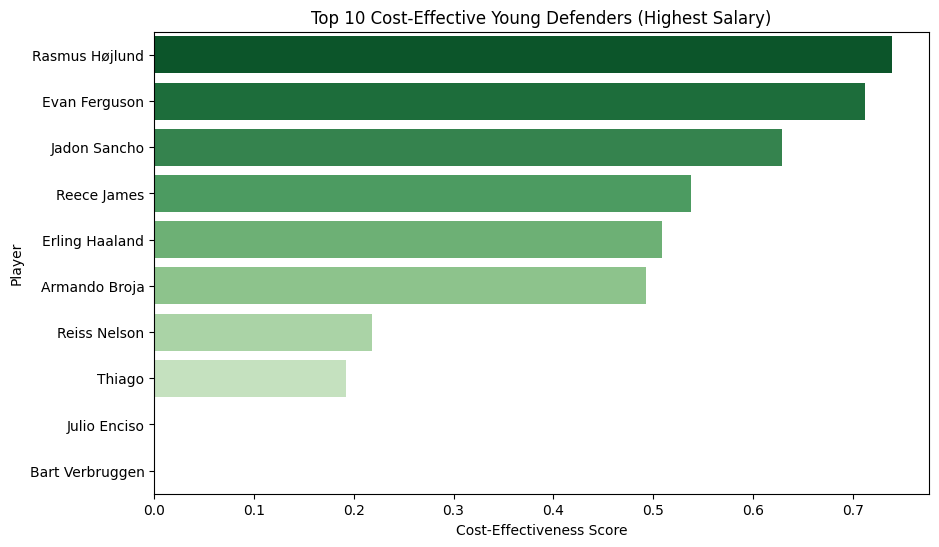

✅ Analysis completed: Top young cost-effective players identified!


In [ ]:
# ==========================
# 8️⃣ Data Visualization
# ==========================

# Plot attackers ordered by lowest salary
plt.figure(figsize=(10, 6))
sns.barplot(x="cost_effectiveness", y="player", data=young_attackers.head(10), palette="Blues_r")
plt.title("Top 10 Cost-Effective Young Attackers (Lowest Salary)")
plt.xlabel("Cost-Effectiveness Score")
plt.ylabel("Player")
plt.show()

# Plot attackers ordered by highest salary
plt.figure(figsize=(10, 6))
sns.barplot(x="cost_effectiveness", y="player", data=young_attackers.tail(10), palette="Blues_r")
plt.title("Top 10 Cost-Effective Young Attackers (Highest Salary)")
plt.xlabel("Cost-Effectiveness Score")
plt.ylabel("Player")
plt.show()

# Plot defenders ordered by lowest salary
plt.figure(figsize=(10, 6))
sns.barplot(x="cost_effectiveness", y="player", data=young_defenders.head(10), palette="Greens_r")
plt.title("Top 10 Cost-Effective Young Defenders (Lowest Salary)")
plt.xlabel("Cost-Effectiveness Score")
plt.ylabel("Player")
plt.show()

# Plot defenders ordered by highest salary
plt.figure(figsize=(10, 6))
sns.barplot(x="cost_effectiveness", y="player", data=young_defenders.tail(10), palette="Greens_r")
plt.title("Top 10 Cost-Effective Young Defenders (Highest Salary)")
plt.xlabel("Cost-Effectiveness Score")
plt.ylabel("Player")
plt.show()

print("✅ Analysis completed: Top young cost-effective players identified!")


In [ ]:
young_attackers.columns

Index(['league', 'season', 'team', 'player', 'nation', 'pos', 'age', 'born',
       '90s', 'SCA_SCA', 'SCA_SCA90', 'SCA Types_PassLive',
       'SCA Types_PassDead', 'SCA Types_TO', 'SCA Types_Sh', 'SCA Types_Fld',
       'SCA Types_Def', 'GCA_GCA', 'GCA_GCA90', 'GCA Types_PassLive',
       'GCA Types_PassDead', 'GCA Types_TO', 'GCA Types_Sh', 'GCA Types_Fld',
       'GCA Types_Def', 'salary', 'cost_effectiveness'],
      dtype='object')

In [ ]:
young_attackers.columns

Index(['league', 'season', 'team', 'player', 'nation', 'pos', 'age', 'born',
       '90s', 'SCA_SCA', 'SCA_SCA90', 'SCA Types_PassLive',
       'SCA Types_PassDead', 'SCA Types_TO', 'SCA Types_Sh', 'SCA Types_Fld',
       'SCA Types_Def', 'GCA_GCA', 'GCA_GCA90', 'GCA Types_PassLive',
       'GCA Types_PassDead', 'GCA Types_TO', 'GCA Types_Sh', 'GCA Types_Fld',
       'GCA Types_Def', 'salary', 'cost_effectiveness'],
      dtype='object')

In [ ]:
young_defenders.columns

Index(['league', 'season', 'team', 'player', 'nation', 'pos', 'age', 'born',
       '90s', 'Tackles_Tkl', 'Tackles_TklW', 'Tackles_Def 3rd',
       'Tackles_Mid 3rd', 'Tackles_Att 3rd', 'Challenges_Tkl',
       'Challenges_Att', 'Challenges_Tkl%', 'Challenges_Lost', 'Blocks_Blocks',
       'Blocks_Sh', 'Blocks_Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'salary',
       'cost_effectiveness'],
      dtype='object')

In [ ]:
# ==========================
# 8️⃣ Fix Duplicate Player Names Before Mapping Misc Stats
# ==========================
player_misc_stats = player_misc_stats.drop_duplicates(subset=["player"]).set_index("player")

# Map fouls and errors data from misc stats
young_attackers["Performance_Fls"] = young_attackers["player"].map(player_misc_stats["Performance_Fls"])
young_defenders["Performance_Fls"] = young_defenders["player"].map(player_misc_stats["Performance_Fls"])

# ==========================
# 9️⃣ Basic Statistics for Attackers & Defenders
# ==========================
def plot_distribution(df, metric, title, color):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[metric], bins=20, kde=True, color=color)
    plt.axvline(df[metric].mean(), color='black', linestyle='dashed', linewidth=2, label=f"Mean: {df[metric].mean():.2f}")
    plt.axvline(df[metric].median(), color='purple', linestyle='dashed', linewidth=2, label=f"Median: {df[metric].median():.2f}")
    plt.axvline(df[metric].mode()[0], color='orange', linestyle='dashed', linewidth=2, label=f"Mode: {df[metric].mode()[0]:.2f}")
    plt.axvline(df[metric].std(), color='red', linestyle='dotted', linewidth=2, label=f"Std Dev: {df[metric].std():.2f}")
    plt.legend()
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.show()

metrics_attackers = ["GCA_GCA", "salary", "Performance_Fls"]
titles_attackers = ["Goal Creating Actions", "Salary", "Fouls Committed"]

metrics_defenders = ["Tackles_Tkl", "salary", "Performance_Fls"]
titles_defenders = ["Tackles", "Salary", "Fouls Committed"]

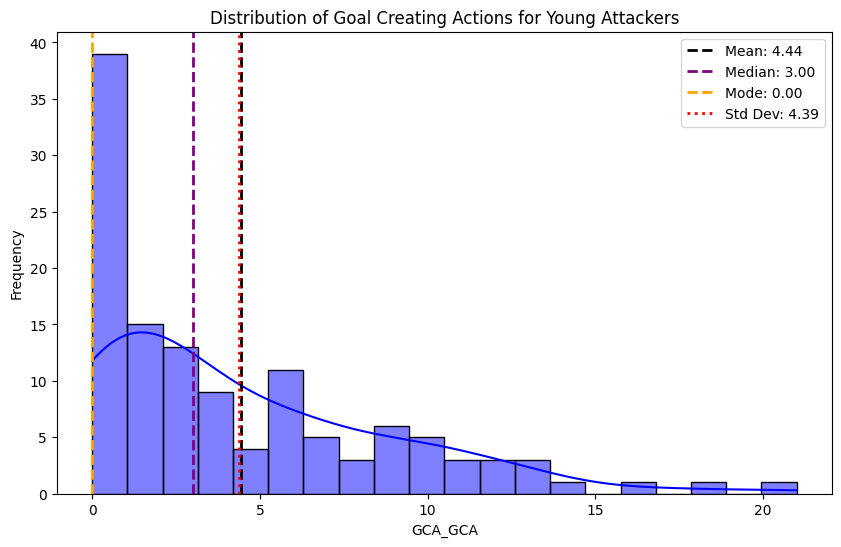

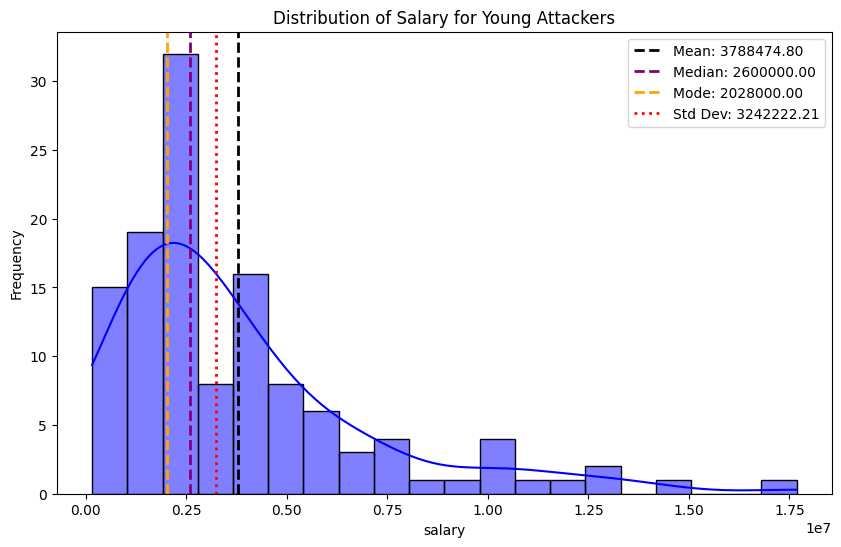

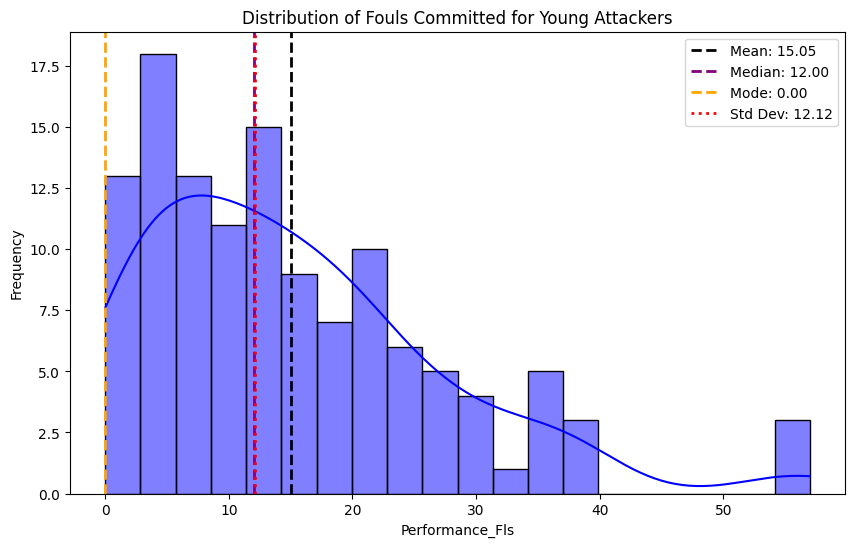

In [ ]:
for metric, title in zip(metrics_attackers, titles_attackers):
    plot_distribution(young_attackers, metric, f"Distribution of {title} for Young Attackers", "blue")


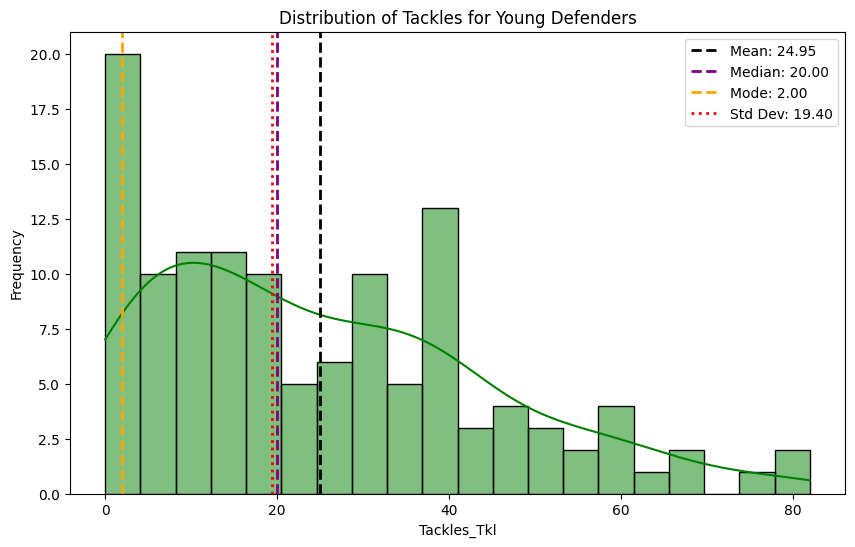

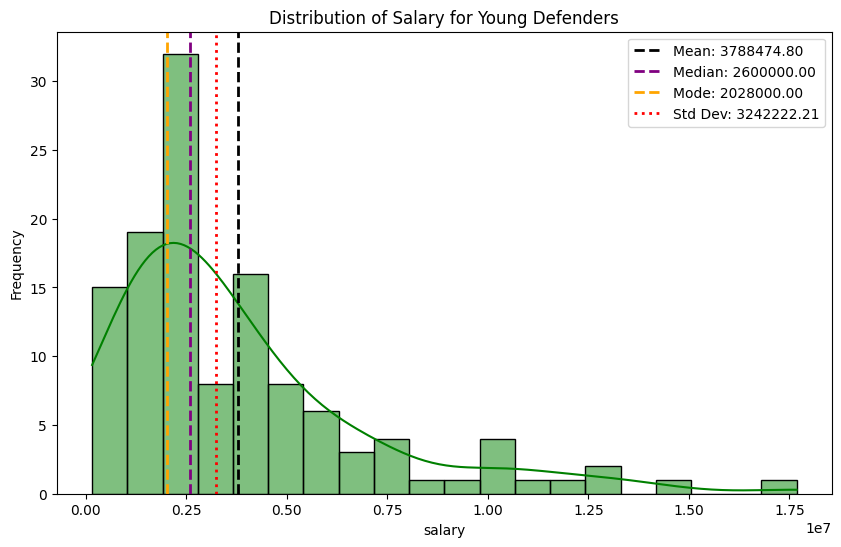

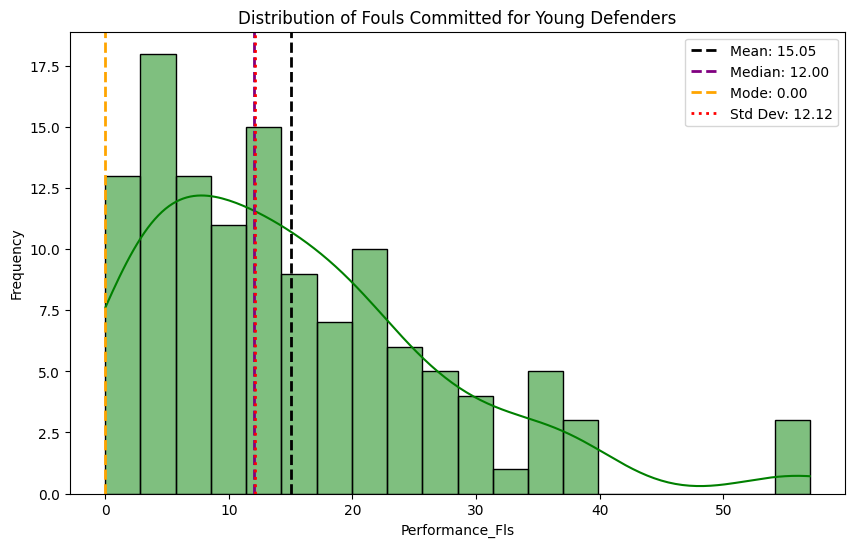

✅ Analysis completed with extended statistics for attackers and defenders!


In [ ]:

for metric, title in zip(metrics_defenders, titles_defenders):
    plot_distribution(young_defenders, metric, f"Distribution of {title} for Young Defenders", "green")

print("✅ Analysis completed with extended statistics for attackers and defenders!")


In [ ]:
young_attackers.columns

Index(['league', 'season', 'team', 'player', 'nation', 'pos', 'age', 'born',
       '90s', 'SCA_SCA', 'SCA_SCA90', 'SCA Types_PassLive',
       'SCA Types_PassDead', 'SCA Types_TO', 'SCA Types_Sh', 'SCA Types_Fld',
       'SCA Types_Def', 'GCA_GCA', 'GCA_GCA90', 'GCA Types_PassLive',
       'GCA Types_PassDead', 'GCA Types_TO', 'GCA Types_Sh', 'GCA Types_Fld',
       'GCA Types_Def', 'salary', 'cost_effectiveness', 'Performance_Fls'],
      dtype='object')

[03/15/25 17:29:36] WARNING  <ipython-input-35-e1d79e92dff6>:31: FutureWarning:                     ]8;id=121422;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=476978;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(x="adjusted_creation_score", y="player",                                
                             data=young_attackers.sort_values(by="adjusted_creation_score",                        
                             ascending=False).head(10), palette="Blues_r")                                         
                                                                                                                   

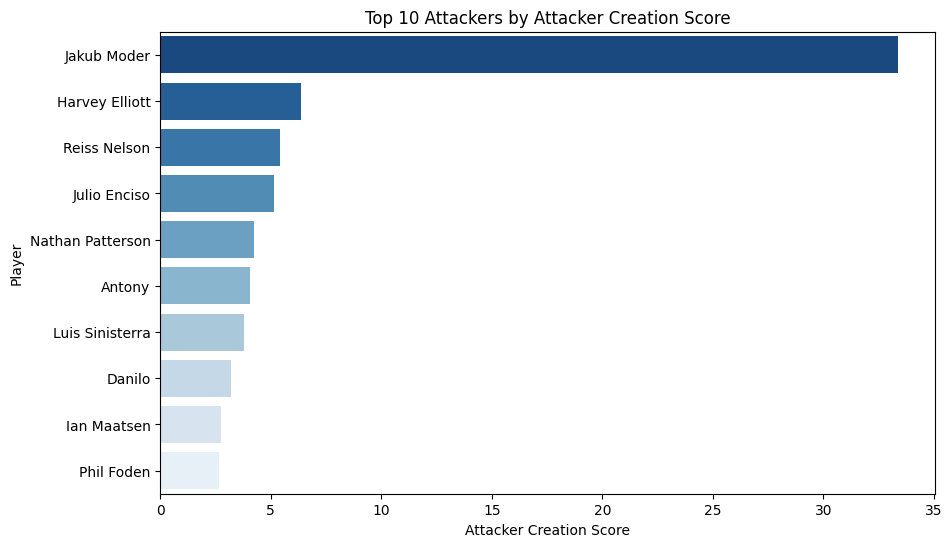

✅ Adjusted creation scores computed and plotted for attackers!


In [ ]:
# ==========================
# 7️⃣ Compute Adjusted Scores for Attackers
# ==========================

# # Ensure 'Performance_Fls' exists before mapping
# if "Performance_Fls" in player_misc_stats.columns:
#     young_attackers = young_attackers.merge(
#         player_misc_stats[["player", "Performance_Fls"]], on="player", how="left"
#     )
#     young_attackers["Performance_Fls"].fillna(0, inplace=True)  # Default to 0 if NaN
# else:
#     young_attackers["Performance_Fls"] = 0  # Default to 0 if column is missing

# Adjusted offensive score
young_attackers["adjusted_creation_score"] = (
    (young_attackers["SCA_SCA"] + young_attackers["SCA_SCA90"] +
     young_attackers["GCA_GCA"] + young_attackers["GCA_GCA90"])
    / (young_attackers["90s"] + 1)  # Avoid division by zero
) - (
    young_attackers["Performance_Fls"] * 0.5 +  # Penalize fouls committed
    young_attackers.get("Performance_Off", 0) * 0.3 +  # Penalize offsides
    young_attackers.get("Performance_PKcon", 0) * 2 +  # Penalize missed penalties
    young_attackers.get("Performance_CrdY", 0) * 1 +  # Penalize yellow cards
    young_attackers.get("Performance_CrdR", 0) * 3  # Penalize red cards
)

# ==========================
# 8️⃣ Plot Adjusted Creation Scores for Attackers
# ==========================
plt.figure(figsize=(10, 6))
sns.barplot(x="adjusted_creation_score", y="player", data=young_attackers.sort_values(by="adjusted_creation_score", ascending=False).head(10), palette="Blues_r")
plt.title("Top 10 Attackers by Attacker Creation Score")
plt.xlabel("Attacker Creation Score")
plt.ylabel("Player")
plt.show()

print("✅ Adjusted creation scores computed and plotted for attackers!")


In [ ]:
from scipy import stats

# ==========================
# 8️⃣ Compute Confidence Interval and Hypothesis Test
# ==========================
confidence_level = 0.95
mean_score = young_attackers["adjusted_creation_score"].mean()
std_dev = young_attackers["adjusted_creation_score"].std()
n = len(young_attackers)

# Compute confidence interval
margin_of_error = stats.t.ppf((1 + confidence_level) / 2., n-1) * (std_dev / np.sqrt(n))
confidence_interval = (mean_score - margin_of_error, mean_score + margin_of_error)

# Hypothesis test: Is the mean adjusted creation score significantly different from 0?
t_statistic, p_value = stats.ttest_1samp(young_attackers["adjusted_creation_score"].dropna(), 0)

print(f"📊 Confidence Interval (95%): {confidence_interval}")
print(f"📊 Hypothesis Test: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

print("✅ Statistical validation completed for adjusted creation scores!")

📊 Confidence Interval (95%): (-5.675273623037299, -3.178489501767898)
📊 Hypothesis Test: t-statistic = -7.0198, p-value = 0.0000
✅ Statistical validation completed for adjusted creation scores!


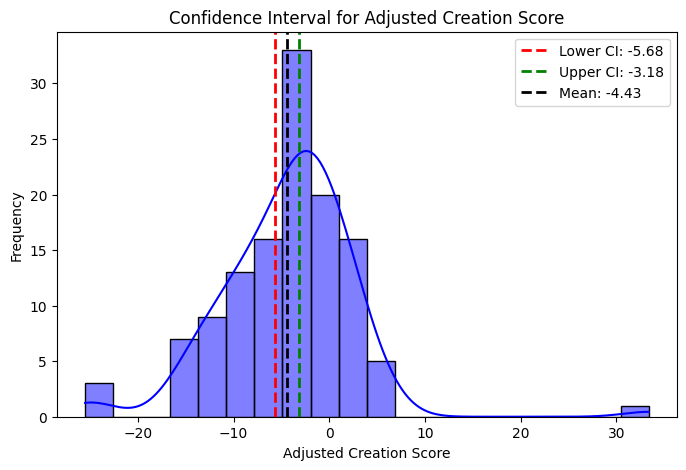

📊 Confidence Interval (95%): (-5.675273623037299, -3.178489501767898)
📊 Hypothesis Test: t-statistic = -7.0198, p-value = 0.0000
✅ Statistical validation completed for adjusted creation scores!


In [ ]:
# ==========================
# 9️⃣ Plot Confidence Interval and Hypothesis Test Results
# ==========================
plt.figure(figsize=(8, 5))
sns.histplot(young_attackers["adjusted_creation_score"], bins=20, kde=True, color="blue")
plt.axvline(confidence_interval[0], color='red', linestyle='dashed', linewidth=2, label=f"Lower CI: {confidence_interval[0]:.2f}")
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2, label=f"Upper CI: {confidence_interval[1]:.2f}")
plt.axvline(mean_score, color='black', linestyle='dashed', linewidth=2, label=f"Mean: {mean_score:.2f}")
plt.legend()
plt.title("Confidence Interval for Adjusted Creation Score")
plt.xlabel("Adjusted Creation Score")
plt.ylabel("Frequency")
plt.show()

print(f"📊 Confidence Interval (95%): {confidence_interval}")
print(f"📊 Hypothesis Test: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

print("✅ Statistical validation completed for adjusted creation scores!")

In [ ]:
# !pip install nbconvert[webpdf] playwright pyppeteer

In [ ]:
# !playwright install

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !jupyter nbconvert --to webpdf /content/drive/My\Drive/proyecto/data-cleaning.ipynb --output "data-cleaning.pdf"